# モデル評価ノートブック

- 日付: 2025-10-09
- 目的: 学習済みモデル（base / sectional）の評価、特徴量名の確認、特徴量重要度（モデル内蔵・パーミュテーション）、SHAP（導入済みの場合）の確認

> 注意: 下の「CONFIG」セルで `APPROACH` や各パスを変更して実行してください。


In [2]:
# === CONFIG ===
APPROACH = "base"  # "base" or "sectional"

# Derived paths
DATA_DIR   = f"data/processed/{APPROACH}"
MODEL_DIR  = f"models/{APPROACH}/latest"

# Optional caps for permutation importance and SHAP sampling
PI_N_REPEATS   = 5
PI_MAX_SAMPLES = 20000  # larger -> slower
SHAP_MAX_SAMPLES = 2000  # if shap is available

print("APPROACH =", APPROACH)
print("DATA_DIR =", DATA_DIR)
print("MODEL_DIR =", MODEL_DIR)


APPROACH = base
DATA_DIR = data/processed/base
MODEL_DIR = models/base/latest


In [3]:
# === Robust loader (repo root autodetect + clear checks) ===
import os, json
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import sparse
from scipy.sparse import load_npz
import joblib

from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, accuracy_score, matthews_corrcoef
from sklearn.inspection import permutation_importance

print("CWD =", os.getcwd())

def find_repo_root(start: Path) -> Path:
    p = start.resolve()
    for q in [p] + list(p.parents):
        if (q/"data").exists() and (q/"models").exists():
            return q
    return p  # fallback

REPO = find_repo_root(Path.cwd())
print("REPO =", REPO)

DATA_DIR = (REPO / DATA_DIR).resolve()
MODEL_DIR = (REPO / MODEL_DIR).resolve()
print("DATA_DIR =", DATA_DIR)
print("MODEL_DIR =", MODEL_DIR)

# --- X / y ---
x_candidates = [DATA_DIR/"X.npz", DATA_DIR/"X_dense.npz"]
x_path = next((p for p in x_candidates if p.exists()), None)
if x_path is None:
    raise FileNotFoundError(
        f"特徴量が見つかりませんでした。\n"
        f"探したパス: {[str(p) for p in x_candidates]}\n"
        f"まず前処理を実行してください：\n"
        f"  python scripts\\preprocess_base_features.py --master data\\processed\\master.csv "
        f"--out-dir data\\processed\\{APPROACH} --pipeline-dir models\\{APPROACH}\\latest"
    )

if x_path.name == "X_dense.npz":
    arr = np.load(x_path)["X"]
    X = sparse.csr_matrix(arr)
else:
    X = load_npz(x_path)

y_path = DATA_DIR/"y.csv"
if not y_path.exists():
    raise FileNotFoundError(f"y.csv が見つかりません: {y_path}\n"
                            "preprocess_base_features.py の実行を確認してください。")
y = pd.read_csv(y_path)["is_top2"].to_numpy().astype(int)

# --- pipeline / model ---
pipe_path = MODEL_DIR / "feature_pipeline.pkl"
if not pipe_path.exists():
    raise FileNotFoundError(f"feature_pipeline.pkl が見つかりません: {pipe_path}\n"
                            "学習前処理の出力先（models/{APPROACH}/latest）を確認してください。")
pipe_obj = joblib.load(pipe_path)
ct = pipe_obj["column_transformer"] if isinstance(pipe_obj, dict) and "column_transformer" in pipe_obj else pipe_obj

def find_model(md: Path):
    for name in ["model.pkl","model.joblib","model.bin"]:
        p = md / name
        if p.exists():
            return p
    return None

model_path = find_model(MODEL_DIR)
if model_path is None:
    raise FileNotFoundError(f"学習済みモデルが見つかりません: {MODEL_DIR}\n"
                            "train.py を実行して latest を更新してください。")

model = joblib.load(model_path)

X.shape, y.shape, type(ct), type(model), str(x_path), str(model_path)


CWD = C:\Users\user\Desktop\Git\ark-blueprints\notebooks
REPO = C:\Users\user\Desktop\Git\ark-blueprints
DATA_DIR = C:\Users\user\Desktop\Git\ark-blueprints\data\processed\base
MODEL_DIR = C:\Users\user\Desktop\Git\ark-blueprints\models\base\latest


((112824, 155),
 (112824,),
 sklearn.compose._column_transformer.ColumnTransformer,
 lightgbm.sklearn.LGBMClassifier,
 'C:\\Users\\user\\Desktop\\Git\\ark-blueprints\\data\\processed\\base\\X_dense.npz',
 'C:\\Users\\user\\Desktop\\Git\\ark-blueprints\\models\\base\\latest\\model.pkl')

In [4]:
from sklearn.compose import ColumnTransformer

def get_feature_names_from_ct(ct) -> list[str]:
    names = []
    try:
        for name, trans, cols in ct.transformers_:
            if name == "remainder" and trans == "drop":
                continue
            if hasattr(trans, "named_steps"):
                last = None
                for _, step in trans.named_steps.items():
                    last = step
                if hasattr(last, "get_feature_names_out"):
                    feats = last.get_feature_names_out(cols)
                    names.extend([str(x) for x in feats])
                    continue
            if hasattr(trans, "get_feature_names_out"):
                feats = trans.get_feature_names_out(cols)
                names.extend([str(x) for x in feats])
            else:
                names.extend([str(c) for c in cols])
        try:
            names2 = ct.get_feature_names_out()
            if len(names2) == len(names):
                names = [str(x) for x in names2]
        except Exception:
            pass
    except Exception as e:
        print("WARN: feature name recovery failed:", e)
        names = [f"feat_{i}" for i in range(X.shape[1])]
    return names

feature_names = get_feature_names_from_ct(ct)
len(feature_names), feature_names[:10]


(155,
 ['num_zero__adv_p1',
  'num_zero__adv_p2',
  'num_zero__adv_p3',
  'num_zero__adv_p4',
  'num_zero__adv_p5',
  'num_zero__adv_p6',
  'num_zero__lr_p1',
  'num_zero__lr_p2',
  'num_zero__lr_p3',
  'num_zero__lr_p4'])

In [5]:
import numpy as np

def safe_predict_proba(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        z = model.decision_function(X)
        return 1.0 / (1.0 + np.exp(-z))
    else:
        yp = model.predict(X)
        return np.clip(yp.astype(float), 0.0, 1.0)

y_prob = safe_predict_proba(model, X)
y_pred = (y_prob >= 0.5).astype(int)

metrics = {
    "auc": float(roc_auc_score(y, y_prob)),
    "pr_auc": float(average_precision_score(y, y_prob)),
    "logloss": float(log_loss(y, y_prob, labels=[0,1])),
    "accuracy": float(accuracy_score(y, y_pred)),
    "mcc": float(matthews_corrcoef(y, y_pred)),
    "n_rows": int(X.shape[0]),
    "n_features": int(X.shape[1]),
}
metrics


{'auc': 0.878725141973305,
 'pr_auc': 0.7878788558637602,
 'logloss': 0.4215382896665399,
 'accuracy': 0.8023115649152662,
 'mcc': 0.5356257687660075,
 'n_rows': 112824,
 'n_features': 155}

## Native Feature Importances

- 概要: モデルが学習中に内部で計算した“使われ方”の指標（木=分割の回数/利得、線形=係数の大きさ等）。軽くて即時に見られる。

- 読み方: 上位=モデルが分岐や重み付けで多用した特徴。連続値/高カード列が上がりやすい“バイアス”に注意。

- 落とし穴: 相関した特徴の片方だけが高く出ることがある（重要度の食い合い）。モデル間で指標の定義が異なり横比較に不向き。

- 使いどころ: 全体の当たり付け・枝刈りの初期候補出し。次にPIやSHAPで裏取り。

In [7]:
import pandas as pd

if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({"feature": feature_names, "importance": model.feature_importances_})
    fi = fi.sort_values("importance", ascending=False).reset_index(drop=True)
    fi.head(20)
else:
    print("model has no feature_importances_")


In [31]:
display(fi.head(30))

,feature,importance
0,num__motor_3rentai_rate,873
1,num__N_winning_rate,856
2,num__age,802
3,num__N_2rentai_rate,765
4,num__boat_2rentai_rate,742
5,num__ST_tenji,736
6,num__N_3rentai_rate,718
7,num__motor_2rentai_rate,702
8,num__weight,685
9,num__boat_3rentai_rate,677


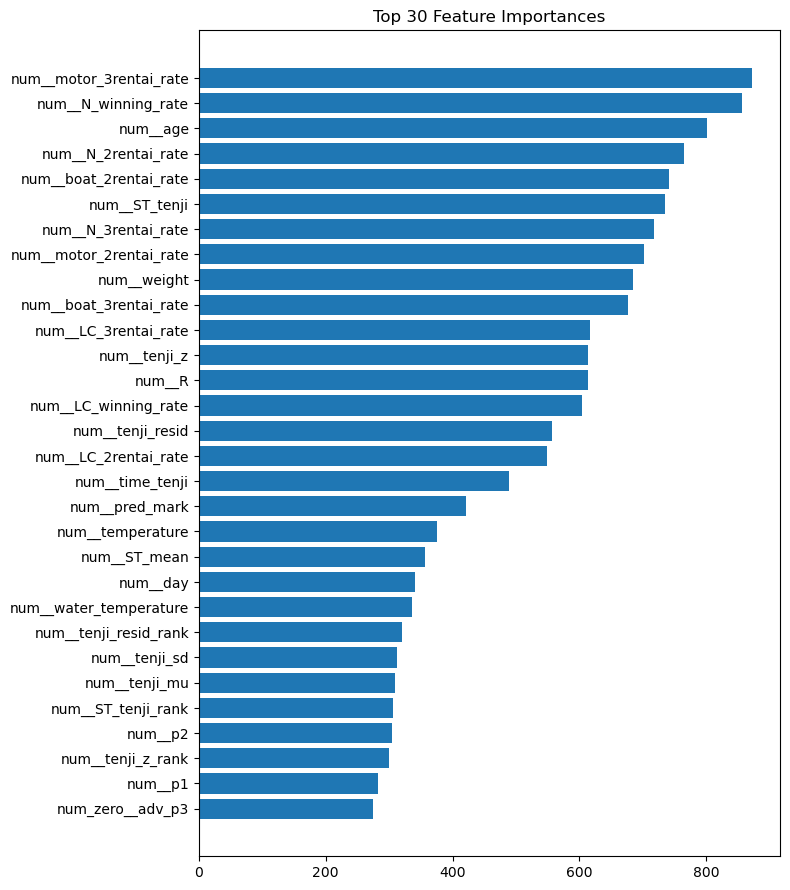

In [8]:
import matplotlib.pyplot as plt

if hasattr(model, "feature_importances_"):
    topk = 30
    top = fi.head(topk).iloc[::-1]
    plt.figure(figsize=(8, max(4, topk*0.3)))
    plt.barh(top["feature"], top["importance"])
    plt.title(f"Top {topk} Feature Importances")
    plt.tight_layout()
    plt.show()


## Permutation Importance (model-agnostic)

- 概要: ある特徴をシャッフルして性能劣化（例：neg_log_lossの悪化）を見る、モデル非依存の実用的な重要度。

- 読み方: 数値が大きいほど“その列を壊すとスコアが悪化”＝実運用で効いている。なるべく**ホールドアウト（OOS）**で実施。

- 落とし穴: 相関が強いと、片方を壊しても他方が代替して薄く見える。疎行列は非対応→dense化/サブサンプルが必要で重い。

- 使いどころ: 実力の裏取り。系列（例：p1..p6, tenji_群, N_群）をグループ同時シャッフルすると相関の影響を減らせる。

,feature,pi_mean,pi_std
0,num__pred_mark,0.024365,0.001018
1,num__N_winning_rate,0.021134,0.000656
2,num__R,0.017535,0.000458
3,num__p1,0.011955,0.000467
4,num__p5,0.011861,0.000422
5,num__age,0.011487,0.000391
6,num__motor_3rentai_rate,0.011030,0.000183
7,num__N_2rentai_rate,0.010763,0.000142
8,num__ST_tenji,0.010233,0.000218
9,num__base_p1,0.008761,0.000234


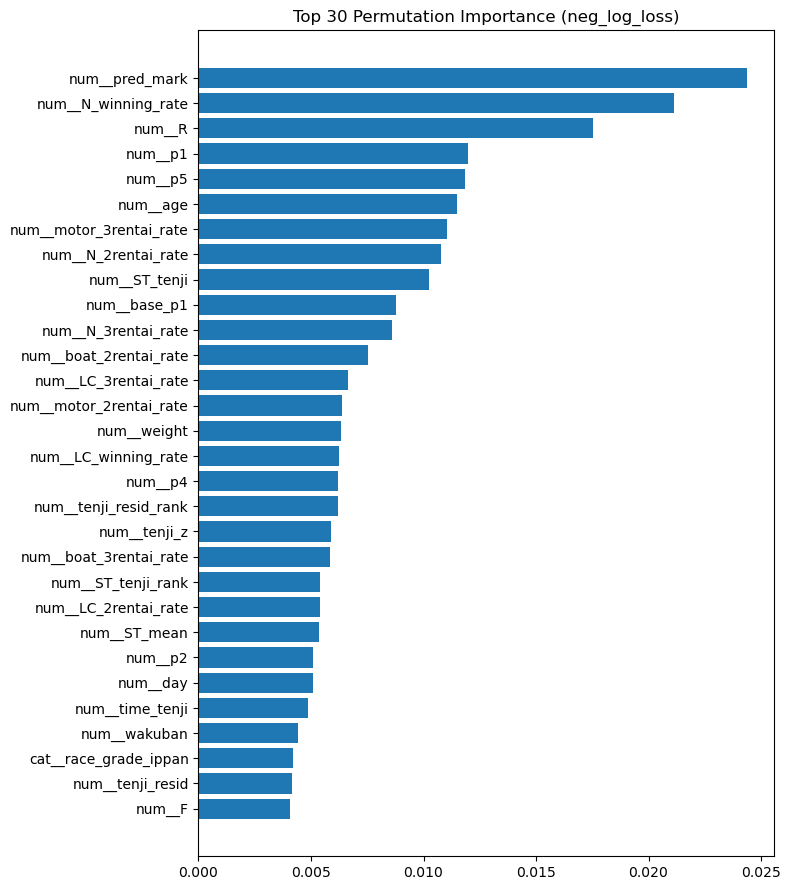

In [34]:
from sklearn.inspection import permutation_importance
from scipy import sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)
n = X.shape[0]
max_n = max(1000, min(PI_MAX_SAMPLES, n))
idx = rng.choice(n, size=max_n, replace=False)

# --- permutation_importance は sparse を受け付けない → dense に変換 ---
Xs = X[idx] if sparse.issparse(X) else X[idx, :]
ys = y[idx]

# メモリ/速度対策：sparse→dense 変換を安全に
def to_dense_safe(M, max_try=3):
    if not sparse.issparse(M):
        return np.asarray(M)
    for _ in range(max_try):
        try:
            return M.toarray()
        except MemoryError:
            # サンプルを半分にして再トライ
            m = M.shape[0] // 2
            M = M[:m]
    # 最後の手段：さらにサンプルを絞って返す
    return M[: min(2000, M.shape[0])].toarray()

Xs_dense = to_dense_safe(Xs)

pi = permutation_importance(
    model, Xs_dense, ys, scoring="neg_log_loss",
    n_repeats=PI_N_REPEATS, random_state=42, n_jobs=-1
)

pi_df = pd.DataFrame({
    "feature": feature_names,
    "pi_mean": pi.importances_mean,
    "pi_std": pi.importances_std
}).sort_values("pi_mean", ascending=False).reset_index(drop=True)

display(pi_df.head(30))

topk = 30
top = pi_df.head(topk).iloc[::-1]
plt.figure(figsize=(8, max(4, topk*0.3)))
plt.barh(top["feature"], top["pi_mean"])
plt.title(f"Top {topk} Permutation Importance (neg_log_loss)")
plt.tight_layout()
plt.show()


## SHAP

- 概要: 1サンプルごとに各特徴の寄与方向（＋/−）と大きさを出す説明法。
ツリーモデルは TreeExplainer が速い／その他は KernelExplainer（遅い）。

- Beeswarm（上図）: 右=陽性寄与、左=陰性寄与。色＝実値（赤=高、青=低）。
赤が右・青が左＝正の寄与、逆なら負。左右に広い列は条件依存/相互作用が強い。

- Bar（下図）: 平均|SHAP|で総合影響量をランク。ロングテールの厚みも把握できる。

- 落とし穴: 背景/サンプリング次第で振れる。高相関だと解釈が難しく、Kernelは重い。
sv の feature_names と data 整合を崩さない（同じ前処理・同じサンプル順）。

- 使いどころ:

- 依存プロットで閾値/非線形/相互作用を可視化（例：shap.plots.scatter(sv[:, "num__tenji_resid"], color=sv[:, "num__ST_tenji"])）。

- 戦略ルール（閾値や掛け目）・特徴のチューニングに反映

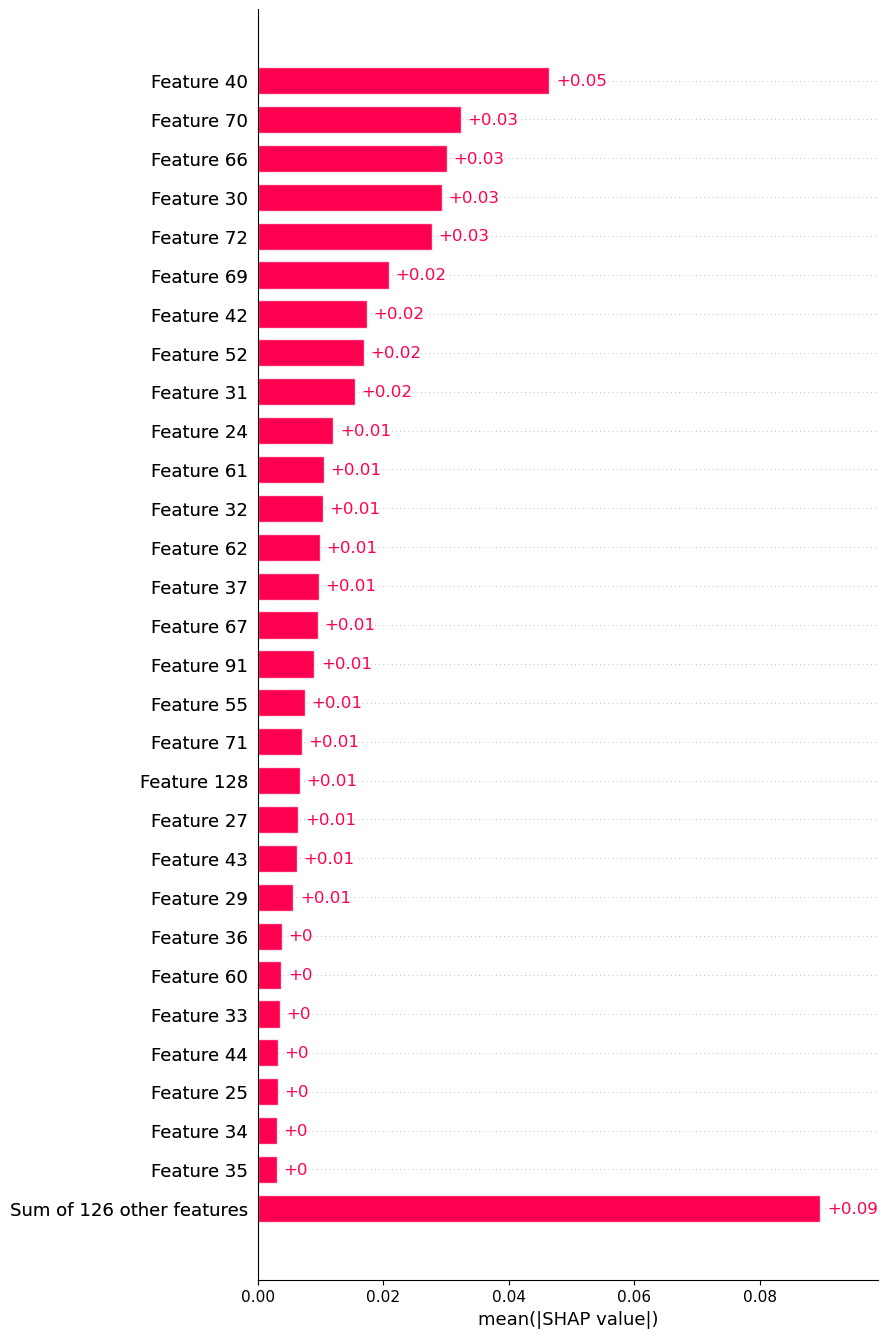

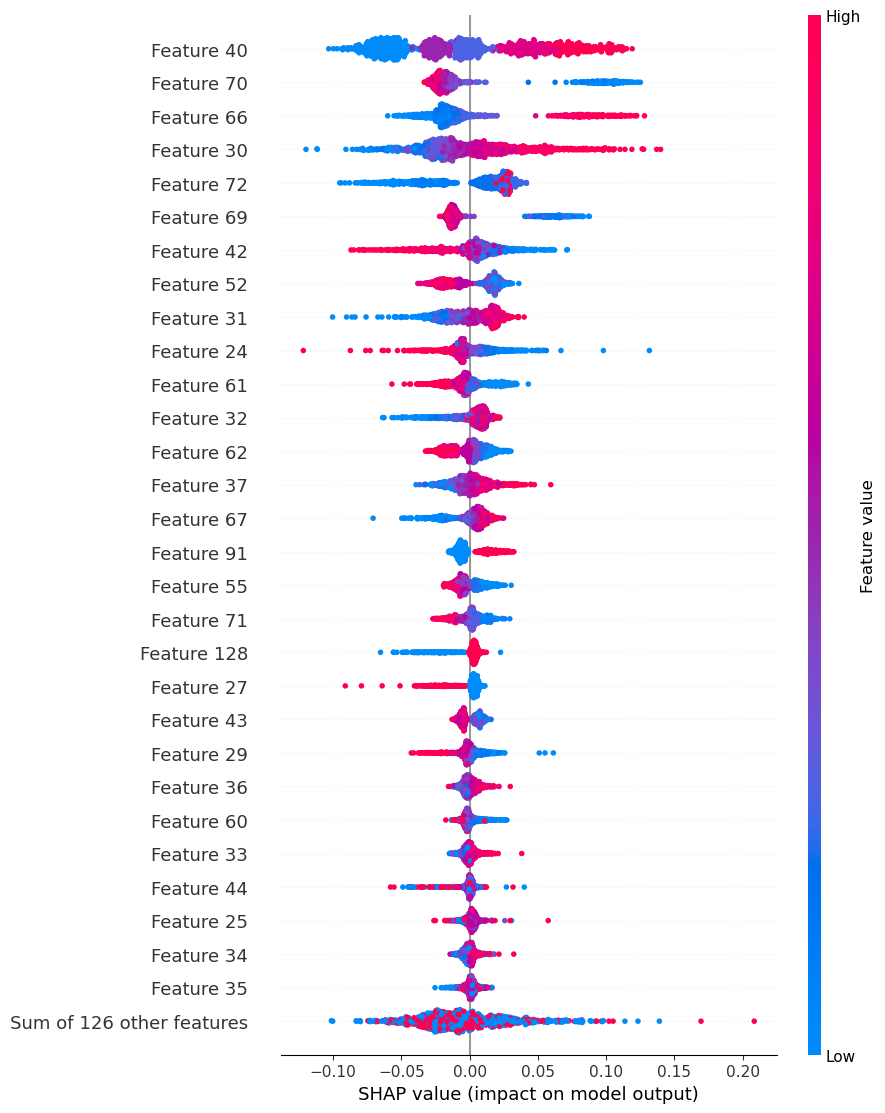

In [36]:
# === Fast SHAP for tree-based models ===
import numpy as np
import shap
from scipy import sparse

# 1) サンプル数を絞る（例: 1000）
k = min(1000, X.shape[0])
rng = np.random.RandomState(0)
idx = rng.choice(X.shape[0], size=k, replace=False)

Xk = X[idx]
if sparse.issparse(Xk):
    # メモリ対策：どうしても厳しければ 1000 → 600 等に落とす
    Xk = Xk.toarray()

# 2) 背景を圧縮（shap.sample or kmeans）
bg = shap.sample(Xk, 100)  # or: shap.kmeans(Xk, 50)

# 3) TreeExplainer（確率出力・加法性チェックオフで高速化）
explainer = shap.TreeExplainer(
    model,
    data=bg,
    feature_perturbation="interventional",
    model_output="probability",
)
sv = explainer(Xk, check_additivity=False)

# 4) 可視化
#shap.plots.bar(sv, max_display=30, show=True)
#shap.plots.beeswarm(sv, max_display=30, show=True)


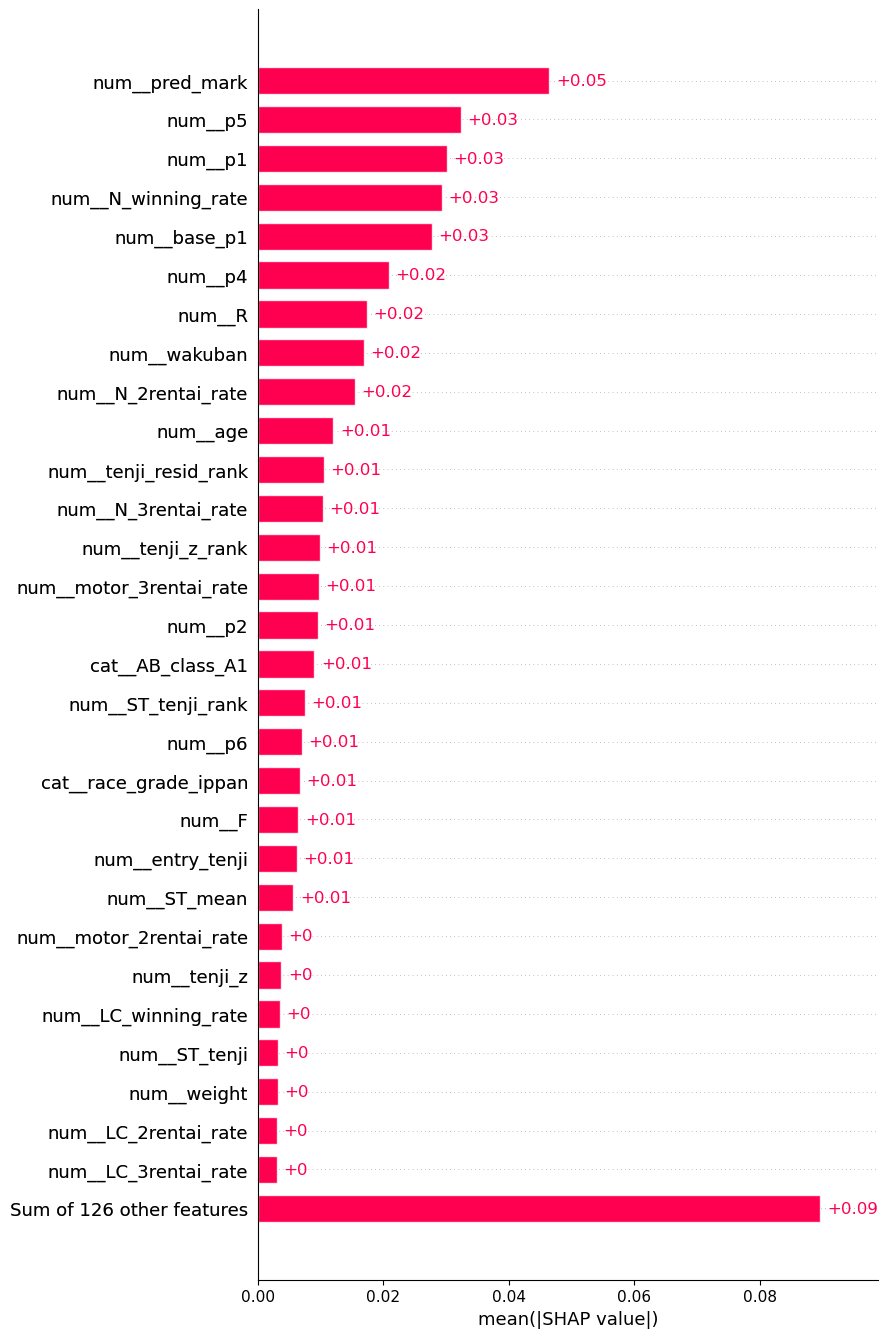

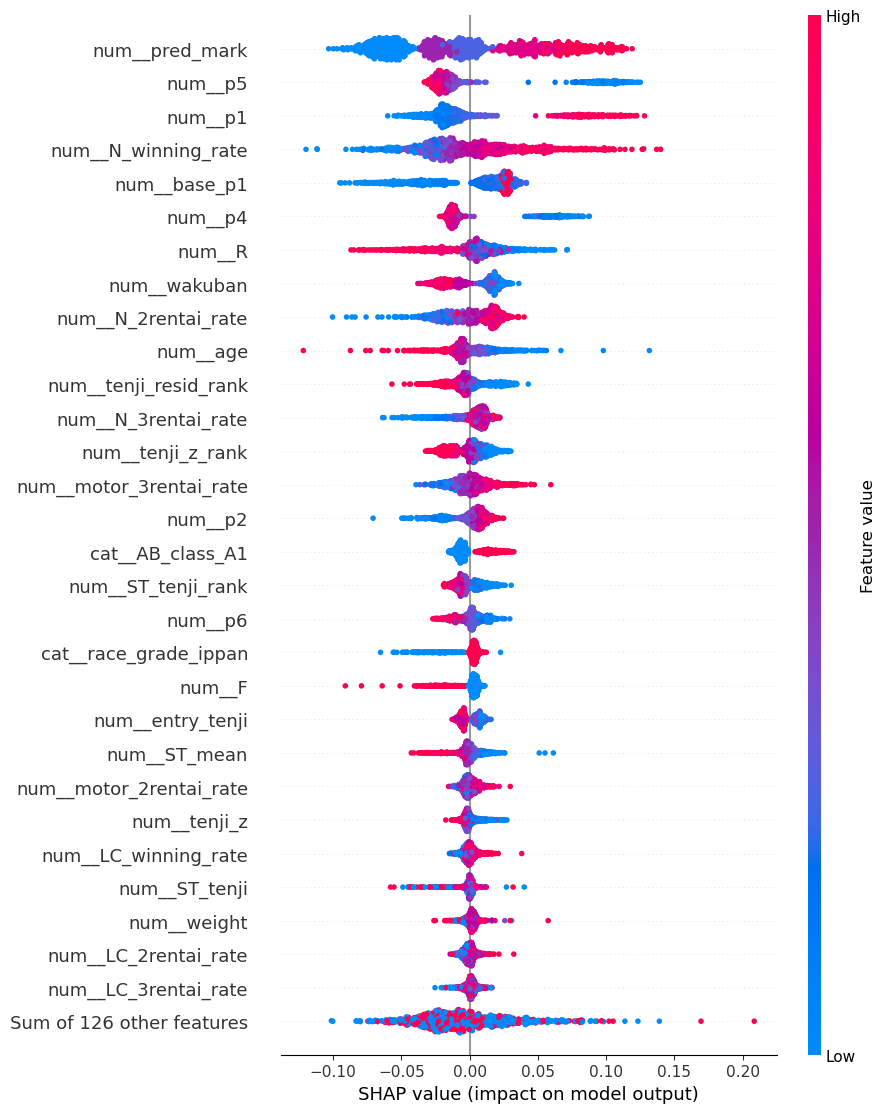

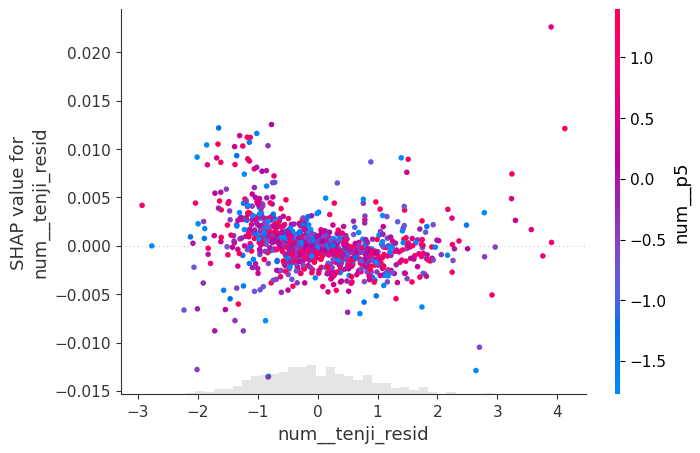

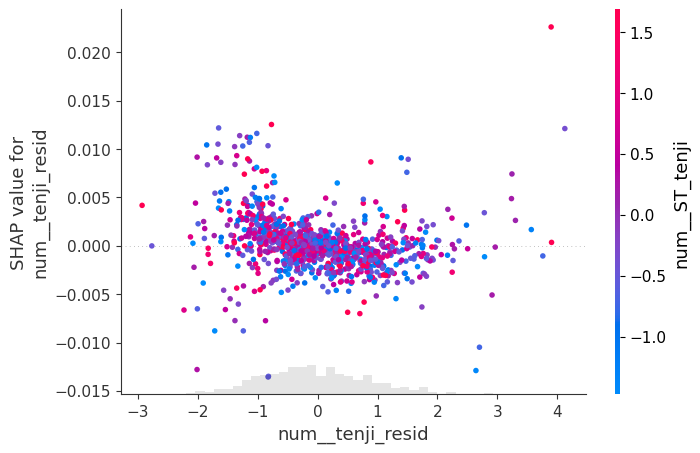

In [58]:
import numpy as np
from scipy import sparse
import shap

# 1) Xk を SHAP実行時と同じものに揃える（疎なら密へ）
Xdata = Xk.toarray() if sparse.issparse(Xk) else Xk

# 2) 列数の整合チェック
assert sv.values.shape[1] == len(feature_names), \
    f"SHAP列={sv.values.shape[1]} と feature_names={len(feature_names)} が不一致"

# 3) 名前とデータを付けて Explanation を作り直す
sv = shap.Explanation(
    values=sv.values,
    base_values=sv.base_values,
    data=Xdata,
    feature_names=feature_names,
)

# 4) これで“名前スライス”が使えます
shap.plots.bar(sv, max_display=30, show=True)  # お試し
shap.plots.beeswarm(sv, max_display=30, show=True)
# 単一特徴の依存プロット（展示残差）
shap.plots.scatter(sv[:, "num__tenji_resid"], color=sv)

# 相互作用っぽさ（色に ST_tenji を乗せる）
shap.plots.scatter(sv[:, "num__tenji_resid"], color=sv[:, "num__ST_tenji"])
